<a href="https://colab.research.google.com/github/RRejuan/2D-time-dependent-heat-equation-using-PINNs-tf2-/blob/main/2D_heat_eq_time_dependent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rifat_Rejuan

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden3 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden4 = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        return self.output_layer(x)

# Hyperparameters
alpha = 1.0  # Thermal diffusivity
learning_rate = 0.001
epochs = 1000

# Initialize the model
model = PINN()

# Define the custom loss function for the transient heat equation
def pinn_loss(model, X, Y, T, boundary_X, boundary_Y, boundary_T, boundary_U):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([X, Y, T])
        U = model(tf.concat([X, Y, T], 1))
        U_x = tape.gradient(U, X)
        U_y = tape.gradient(U, Y)
        U_t = tape.gradient(U, T)
    U_xx = tape.gradient(U_x, X)
    U_yy = tape.gradient(U_y, Y)
    f = U_t - alpha * (U_xx + U_yy)

    boundary_pred = model(tf.concat([boundary_X, boundary_Y, boundary_T], 1))

    f_loss = tf.reduce_mean(tf.square(f))
    boundary_loss = tf.reduce_mean(tf.square(boundary_U - boundary_pred))

    return f_loss + boundary_loss

In [19]:
# Generate synthetic training data
def generate_training_data(num_points):
    X = np.random.uniform(-1, 1, (num_points, 1))
    Y = np.random.uniform(-1, 1, (num_points, 1))
    T = np.random.uniform(0, 1, (num_points, 1))
    return X, Y, T

def generate_boundary_data(num_points):
    # Boundary conditions
    left_X = np.ones((num_points, 1)) * -1
    left_Y = np.linspace(-1, 1, num_points).reshape(num_points, 1)
    left_T = np.random.uniform(0, 1, (num_points, 1))
    left_U = np.ones((num_points, 1)) * 1

    bottom_X = np.linspace(-1, 1, num_points).reshape(-1, 1)
    bottom_Y = np.ones((num_points, 1)) * -1
    bottom_T = np.random.uniform(0, 1, (num_points, 1))
    bottom_U = np.ones((num_points, 1)) * 1/3

    top_X = np.linspace(-1, 1, num_points).reshape(-1, 1)
    top_Y = np.ones((num_points, 1)) * 1
    top_T = np.random.uniform(0, 1, (num_points, 1))
    top_U = np.zeros((num_points, 1))

    right_X = np.ones((num_points, 1)) * 1
    right_Y = np.linspace(-1, 1, num_points).reshape(-1, 1)
    right_T = np.random.uniform(0, 1, (num_points, 1))
    right_U = np.zeros((num_points, 1))

    boundary_X = np.vstack([left_X, bottom_X, top_X, right_X])
    boundary_Y = np.vstack([left_Y, bottom_Y, top_Y, right_Y])
    boundary_T = np.vstack([left_T, bottom_T, top_T, right_T])
    boundary_U = np.vstack([left_U, bottom_U, top_U, right_U])

    return boundary_X, boundary_Y, boundary_T, boundary_U

def generate_initial_data(num_points):
    X = np.random.uniform(-1, 1, (num_points, 1))
    Y = np.random.uniform(-1, 1, (num_points, 1))
    T = np.zeros((num_points, 1))  # Initial condition: t = 0
    U = np.zeros((num_points, 1))  # u(x, y, 0) = 0
    return X, Y, T, U

# Generate data
num_points = 2000
X, Y, T = generate_training_data(num_points)
boundary_X, boundary_Y, boundary_T, boundary_U = generate_boundary_data(num_points)
initial_X, initial_Y, initial_T, initial_U = generate_initial_data(num_points)

# Combine boundary and initial data
boundary_X = np.vstack([boundary_X, initial_X])
boundary_Y = np.vstack([boundary_Y, initial_Y])
boundary_T = np.vstack([boundary_T, initial_T])
boundary_U = np.vstack([boundary_U, initial_U])


Epoch 0: Loss = 0.48216405510902405
Epoch 50: Loss = 0.08472530543804169
Epoch 100: Loss = 0.07776972651481628
Epoch 150: Loss = 0.07338064163923264
Epoch 200: Loss = 0.06943458318710327
Epoch 250: Loss = 0.0653703510761261
Epoch 300: Loss = 0.06077778711915016
Epoch 350: Loss = 0.055693916976451874
Epoch 400: Loss = 0.05086318030953407
Epoch 450: Loss = 0.04679018631577492
Epoch 500: Loss = 0.0433725044131279
Epoch 550: Loss = 0.04042469337582588
Epoch 600: Loss = 0.037802085280418396
Epoch 650: Loss = 0.03554166480898857
Epoch 700: Loss = 0.03360266610980034
Epoch 750: Loss = 0.03194277733564377
Epoch 800: Loss = 0.030572297051548958
Epoch 850: Loss = 0.029424505308270454
Epoch 900: Loss = 0.028437694534659386
Epoch 950: Loss = 0.027573153376579285


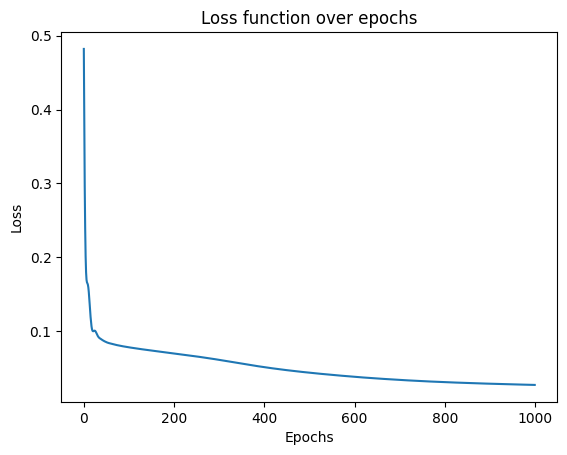

In [20]:
# Prepare training data
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
Y_tf = tf.convert_to_tensor(Y, dtype=tf.float32)
T_tf = tf.convert_to_tensor(T, dtype=tf.float32)
boundary_X_tf = tf.convert_to_tensor(boundary_X, dtype=tf.float32)
boundary_Y_tf = tf.convert_to_tensor(boundary_Y, dtype=tf.float32)
boundary_T_tf = tf.convert_to_tensor(boundary_T, dtype=tf.float32)
boundary_U_tf = tf.convert_to_tensor(boundary_U, dtype=tf.float32)

# Compile the model with the custom loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(X, Y, T, boundary_X, boundary_Y, boundary_T, boundary_U):
    with tf.GradientTape() as tape:
        loss = pinn_loss(model, X, Y, T, boundary_X, boundary_Y, boundary_T, boundary_U)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training loop
loss_history = []
for epoch in range(epochs):
    loss_value = train_step(X_tf, Y_tf, T_tf, boundary_X_tf, boundary_Y_tf, boundary_T_tf, boundary_U_tf)
    loss_history.append(loss_value.numpy())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss_value.numpy()}")

# Plot the loss function over epochs
plt.figure()
plt.plot(range(epochs), loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss function over epochs')
plt.show()

# Save the trained model using the TensorFlow SavedModel format
model.save("transient_heat_model")


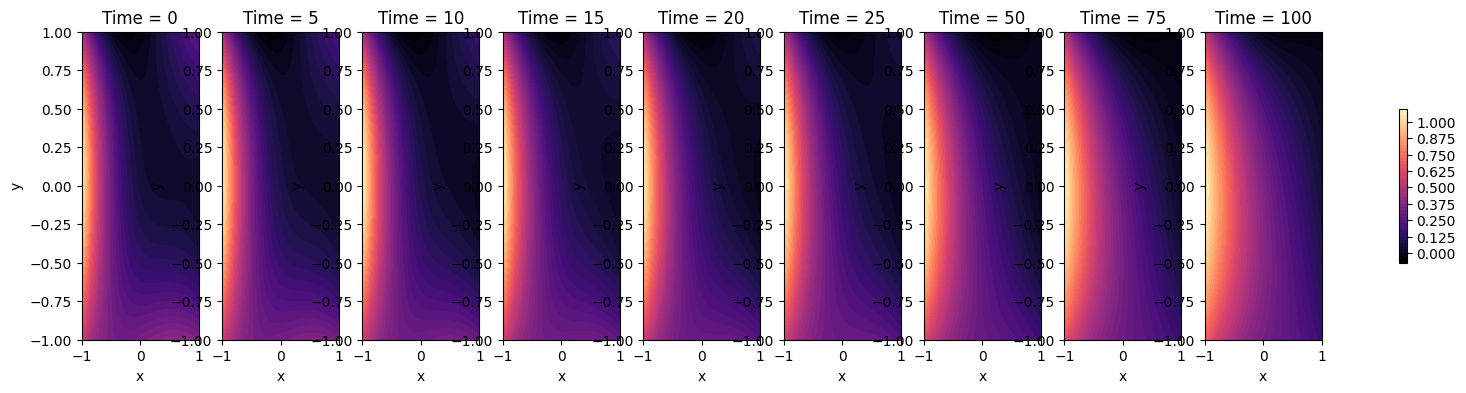

In [21]:
# Define a function to predict the temperature distribution
def predict_temperature(model, X, Y, T):
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    Y_tf = tf.convert_to_tensor(Y, dtype=tf.float32)
    T_tf = tf.convert_to_tensor(T, dtype=tf.float32)
    inputs = tf.concat([X_tf, Y_tf, T_tf], axis=1)
    return model(inputs).numpy()

# Generate grid for visualization
x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_grid_flat = X_grid.flatten().reshape(-1, 1)
Y_grid_flat = Y_grid.flatten().reshape(-1, 1)

# Create heat maps for specified time steps
time_steps = [0, 5, 10, 15, 20, 25, 50,75,100]
fig, axes = plt.subplots(1, len(time_steps), figsize=(20, 4))
for i, t in enumerate(time_steps):
    T_grid_flat = np.ones_like(X_grid_flat) * (t / max(time_steps))
    temp_distribution = predict_temperature(model, X_grid_flat, Y_grid_flat, T_grid_flat)
    temp_distribution_reshaped = temp_distribution.reshape(X_grid.shape)
    im = axes[i].contourf(X_grid, Y_grid, temp_distribution_reshaped, cmap='magma', levels=50)
    axes[i].set_title(f'Time = {t}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()


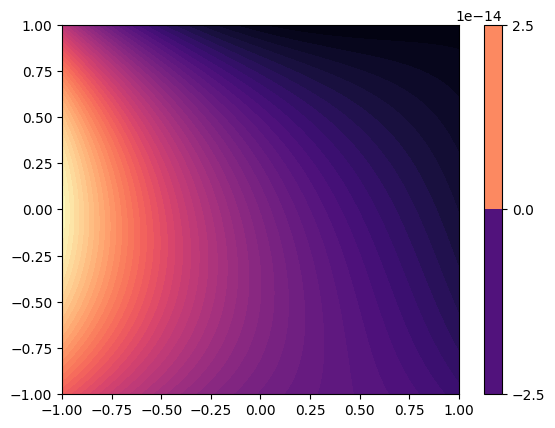

In [22]:
# Create a figure for the animation
fig, ax = plt.subplots()
contour = ax.contourf(X_grid, Y_grid, np.zeros_like(X_grid), cmap='magma')
plt.colorbar(contour)

def update(frame):
    T_grid_flat = np.ones_like(X_grid_flat) * frame / 100  # Normalize time
    temp_distribution = predict_temperature(model, X_grid_flat, Y_grid_flat, T_grid_flat)
    temp_distribution_reshaped = temp_distribution.reshape(X_grid.shape)
    ax.clear()
    contour = ax.contourf(X_grid, Y_grid, temp_distribution_reshaped, cmap='magma', levels=50)
    return contour.collections

# Create animation
ani = animation.FuncAnimation(fig, update, frames=100, blit=False, repeat=True)
ani.save("temperature_evolution.gif", writer='imagemagick')

plt.show()

